In [13]:
# Today we're building our first yield curves! Really exciting stuff.
# We'll be using the QuantLib library to help us with the heavy lifting.
# And also the good old numpy and matplotlib for data manipulation and visualization.

import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import yfinance as yf
import scipy.optimize as sco
from scipy.optimize import brentq
import pandas_datareader as pdr

In [9]:
# Example bonds: assume annual coupons
bonds = [
    {"maturity": 1, "price": 86, "coupon": 2, "face": 100},
    {"maturity": 2, "price": 96, "coupon": 2, "face": 100},
    {"maturity": 3, "price": 90, "coupon": 2, "face": 100},
    {"maturity": 4, "price": 92, "coupon": 2, "face": 100},
]

# Spot rate list to be bootstrapped
spot_rates = []

In [10]:
# Bootstrap each bond
for bond in bonds:
    T = bond["maturity"]
    C = bond["coupon"]
    P = bond["price"]
    FV = bond["face"]
    
    # Generate cash flows and times
    cashflows = [C] * (T - 1) + [C + FV]
    times = np.arange(1, T + 1)
    
    # Discount earlier cashflows using already bootstrapped spot rates
    discounted = 0.0
    for t, cf in zip(times[:-1], cashflows[:-1]):
        r = spot_rates[t - 1]
        discounted += cf / (1 + r) ** t

    print(f"Trying to solve for maturity {T}")
    print(f"f(0.0001) = {f(0.0001):.6f}")
    print(f"f(0.20) = {f(0.20):.6f}")
    
    # Solve for unknown spot rate
    def f(rn):
        return discounted + cashflows[-1] / (1 + rn) ** T - P

    rn = brentq(f, 0.0001, 0.50)  # Find root
    spot_rates.append(rn)
    print(f"Bootstrapped spot rate for maturity {T} years: {rn:.4%}")

Trying to solve for maturity 1
f(0.0001) = 15.989801
f(0.20) = -1.000000
Bootstrapped spot rate for maturity 1 years: 18.6047%
Trying to solve for maturity 2
f(0.0001) = 7.665878
f(0.20) = -23.480392
Bootstrapped spot rate for maturity 2 years: 3.9950%
Trying to solve for maturity 3
f(0.0001) = 15.504969
f(0.20) = -27.436659
Bootstrapped spot rate for maturity 3 years: 5.6625%
Trying to solve for maturity 4
f(0.0001) = 15.190155
f(0.20) = -37.579241
Bootstrapped spot rate for maturity 4 years: 4.1259%


Year 1: Spot rate = 18.60%
Year 2: Spot rate = 4.00%
Year 3: Spot rate = 5.66%
Year 4: Spot rate = 4.13%


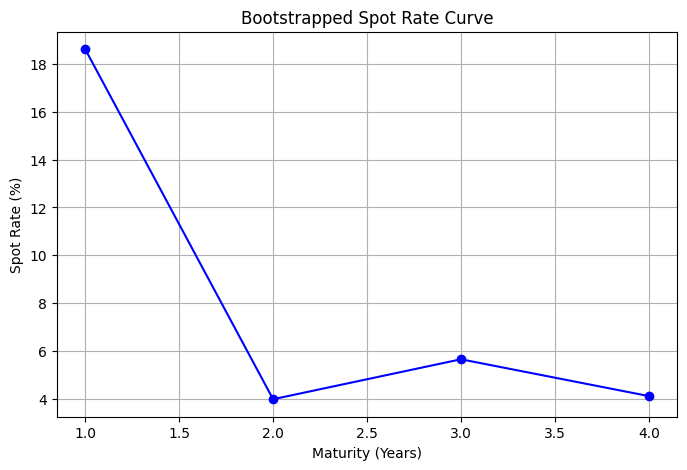

In [11]:
# Display results
for i, r in enumerate(spot_rates):
    print(f"Year {i+1}: Spot rate = {r*100:.2f}%")

# Plot yield curve
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(spot_rates)+1), [r*100 for r in spot_rates], marker='o', color='blue')
plt.title("Bootstrapped Spot Rate Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Spot Rate (%)")
plt.grid(True)
plt.show()

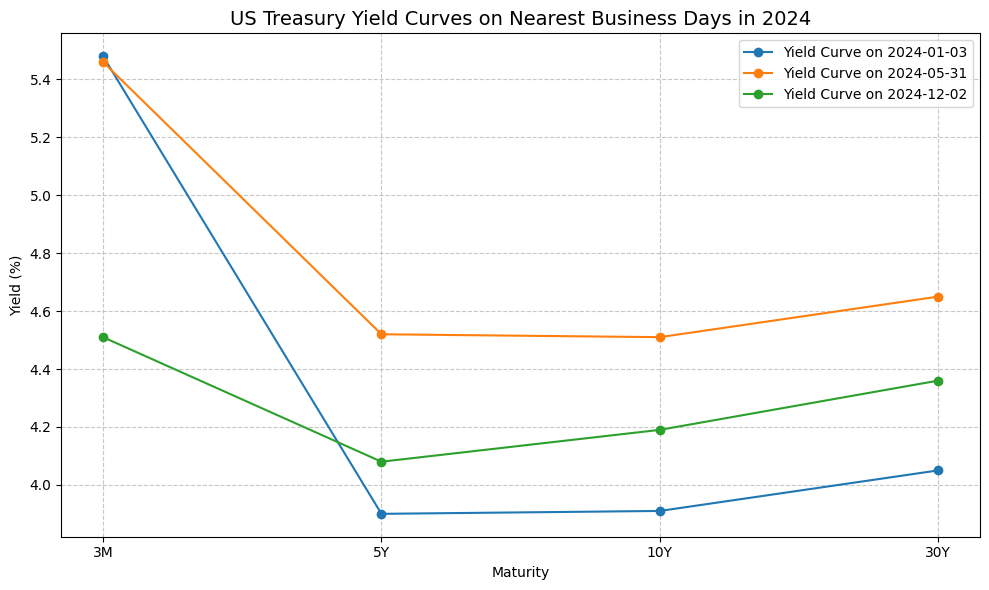

: 

In [ ]:


# --- Load data from FRED ---
start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2024, 12, 31)
tickers = ['DGS3MO', 'DGS5', 'DGS10', 'DGS30']
labels = ['3M', '5Y', '10Y', '30Y']
data = pdr.DataReader(tickers, 'fred', start, end)
data.columns = labels
data.dropna(inplace=True)

# --- Convert to datetime index for matching ---
data.index = pd.to_datetime(data.index)

# --- Target dates (will match nearest available) ---
input_dates = ['2024-01-03', '2024-06-01', '2024-12-01']
curve_dates = []

for d in input_dates:
    target = pd.to_datetime(d)
    closest = data.index[data.index.get_indexer([target], method='nearest')[0]]
    curve_dates.append(str(closest.date()))

# --- Plotting ---
plt.figure(figsize=(10, 6))
for date in curve_dates:
    yields = data.loc[date]
    plt.plot(labels, yields, marker='o', label=f'Yield Curve on {date}')

plt.title('US Treasury Yield Curves on Nearest Business Days in 2024', fontsize=14)
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
